In [403]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import tree
import seaborn as sns
import graphviz
from sklearn.metrics import accuracy_score,confusion_matrix
import numpy as np
from sklearn.model_selection import KFold

# Iris flower species classification
There are 50 samples from each of the three species (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample:  the length and the width of the sepals and petals, in centimeters.

The goal is to use these features to classify the three species.

In [404]:
data = load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### Exploratory data analysis

Before doing anything fancy, we need to figure out if there are any trends that might be useful. It is always a good idea to visualize and understand the data you have.

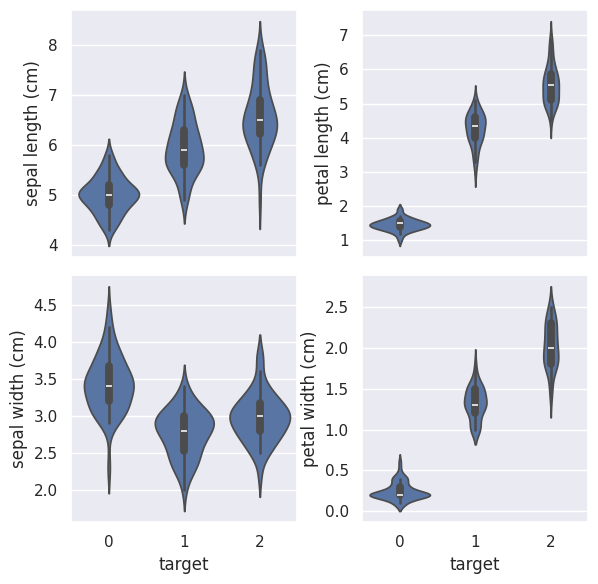

In [405]:
fig,ax = plt.subplots(2,2,sharex=True,figsize=(6,6))
sns.violinplot(data=df,x='target',y=data.feature_names[0],ax=ax[0][0])
sns.violinplot(data=df,x='target',y=data.feature_names[1],ax=ax[1][0])
sns.violinplot(data=df,x='target',y=data.feature_names[2],ax=ax[0][1])
sns.violinplot(data=df,x='target',y=data.feature_names[3],ax=ax[1][1])
plt.tight_layout()

### Takeaways
- It is clear that the order from most to least important features appear to be petal width, petal length, sepal length, and sepal width.
- Iris setosa (target 0) appears to be easily distinguishable while target 1 and 2 appear more difficult.
- Decision trees seem like a good choice because the dataset is small and the relationships are simple enough that we can expect to easily interpret them

In [406]:
print("Target: 0,1,2")
print(data.target_names)

Target: 0,1,2
['setosa' 'versicolor' 'virginica']


### Now time to build a machine learning model to solve this classification task

The goal is to estimate likely performance of a model on out-of-sample data. It would not be useful us to make an overly complex model that overfits to the training data. If we do this, the model likely will not generalize well to unseen data.

That is why we split our data into a training and testing set.

In [407]:
# test_size: what proportion of original data is used for test set
X = df[data.feature_names]
y = df['target']
X_train, X_test, Y_train, Y_test = train_test_split(X,y,train_size = .75,random_state=0)

In [408]:
df.shape # 4 features and 1 target, 150 samples
X_train.shape #4 features, 0.75*150=112 samples
Y_train.shape # 1 target, 112 samples

(112,)

### Initialize the Decision Tree Classifier, fit it to the training data, and compare predictions using `score`

In [409]:
clf = DecisionTreeClassifier(max_depth = 4, #number of splits done going from root to leaf
                             random_state = 0)
clf.fit(X_train, Y_train)
score = clf.score(X_test, Y_test) #same as accuracy_score(Y_test, clf.predict(X_test))
Y_pred = clf.predict(X_test)
print(f"The accuracy of this model is {score*100:.1f}%") #97.4% of the predictions are correct

The accuracy of this model is 97.4%


### Visualize the decision tree

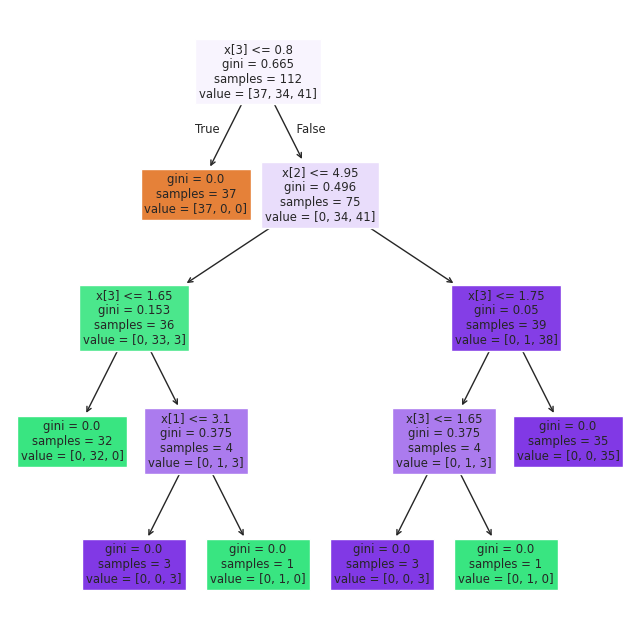

In [410]:
plt.figure(figsize=(8,8))
plot_tree(clf, filled=True);

### Interpretation of above decision tree
- darker shading mean more pure split (this is good)
- color represents the the majority predicted class. For example, orange means class 0, green means class 1, purple means class 2
- In the root node, the fact that there are similar amounts of samples for each target means are dataset is well balanced. It also explains why the shading is light. The gini value of 0.665 is high because the data is **impure**
-  The first split is on the third feature (`petal length (cm)`). Clearly it did a great job classifying the dark orange, class 0 samples. Gini=0.0 meaning the split was **pure**.
- Why was this specific split chosen for the continuous features? The algorithm sorts all values in ascending order and then it calculates potential split thesholds at midpoints between consecutive unique values. It then calculates impurity at each threshold. Finally it selects the best threshold. This is compared to the impurities for all the other features and their thresholds.
- This process is done recursively until the stopping criteria is met.
- As we go down the tree we do see some sketchy splits that may not generalize well. For example, in the fourth split, on the left side of the graph where `x[1] <= 3.1` (sepal width) this is not a very interpretable split. It likely would not generalize well.

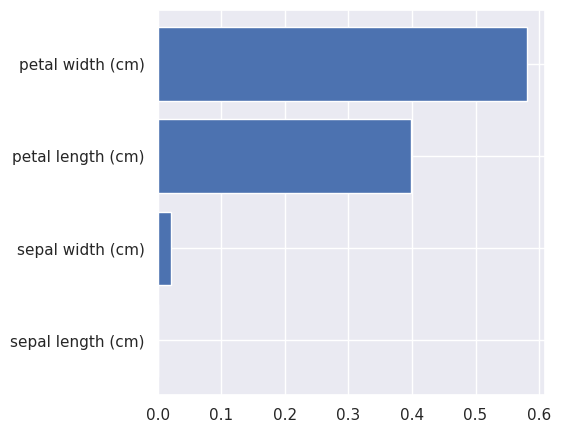

In [411]:
feature_importances = clf.feature_importances_
# Sort the feature importances from greatest to least using the sorted indices
sorted_indices = feature_importances.argsort()
sorted_feature_names = np.array(data.feature_names)[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Create a bar plot of the feature importances
plt.figure(figsize=(5,5))
plt.barh(sorted_feature_names,sorted_importances);

As we suspected the petal width and length are the strongest indicators. We probably will get results that are just as accurate if we only use these two features.

### Evaluating the model

We can compare the training and testing set scores. Since they are essentially the same, we can say that the model is not overfitting.

In [412]:
score_test = clf.score(X_test, Y_test)
score_train = clf.score(X_train, Y_train)
print(f"Training set score: {score_train:.2f}")
print(f"Testing set score: {score_test:.2f}")

Training set score: 1.00
Testing set score: 0.97


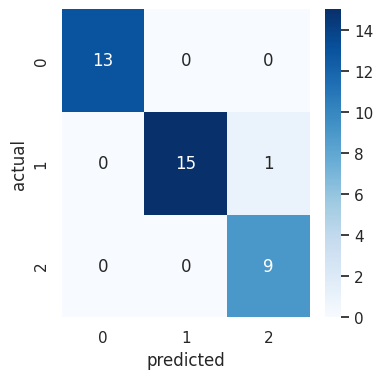

In [414]:
cf = confusion_matrix(Y_test,Y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cf,annot=True,cmap='Blues', fmt='g')
plt.xlabel("predicted")
plt.ylabel("actual");

### But what if we got lucky (or unlucky) in our train-test-split?

That's when cross-validation comes in. Cross-validation is a technique for evaluating ML models by training several ML models on subsets of the available input data and evaluating them on the complementary subset of the data. Use cross-validation to detect overfitting, ie, failing to generalize a pattern.

It's really helpful for assessing how well a statistical analysis will generalize to unseen data.

Note, that when we do cross-validation in the way we do below and then make decisions to improve our model, this will cause data leakage. It would be more accurate to call this train-validation-split. If we truly want to quantify how well it does on unseen data, we need to make sure it truly has not seen the data!

In [450]:
np.random.seed(1)
kf = KFold(n_splits=5, shuffle=True) #150/30 = 5 #ITS IMPORTANT THAT THIS IS SHUFFLED

In [451]:
accuracy_list = []
for train_index, test_index in kf.split(X,y):
  clf = DecisionTreeClassifier(random_state = 0)
  clf.fit(X.iloc[train_index], y.iloc[train_index])
  score = clf.score(X.iloc[test_index], y.iloc[test_index])
  accuracy_list.append(score)
print(accuracy_list)
print(f"Mean accuracy is {np.mean(accuracy_list):.2f}")

[0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9333333333333333, 0.8333333333333334]
Mean accuracy is 0.93


The accuracy is as low as 83% which is a bit concerning. We are likely overfitting to our training set!

### How to improve models

In the last model, there seems to be some trouble distinguishing between the class 1 and 2. This appears to be some over-fitting! How can we address this?

Training set score: 1.00
Testing set score: 0.83


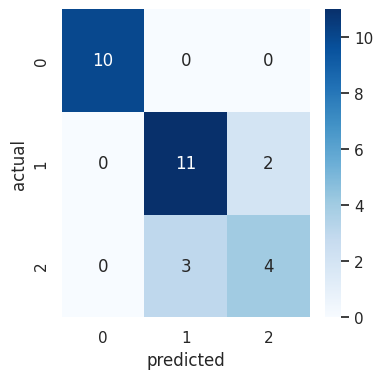

In [453]:
clf_of  = clf #of stands for overfit
X_train_of = X.iloc[train_index]
y_train_of = y.iloc[train_index]
X_test_of = X.iloc[test_index]
y_test_of =  y.iloc[test_index]
y_pred_of = clf.predict(X_test_of)

score_test = clf.score(X_test_of, y_test_of)
score_train = clf.score(X_train_of,y_train_of)
print(f"Training set score: {score_train:.2f}")
print(f"Testing set score: {score_test:.2f}")

cf = confusion_matrix(y_test_of,y_pred_of)
plt.figure(figsize=(4,4))
sns.heatmap(cf,annot=True,cmap='Blues', fmt='g')
plt.xlabel("predicted")
plt.ylabel("actual");

In [454]:
# uncomment to see the decision tree
# plt.figure(figsize=(7,7))
# plot_tree(clf_of, filled=True);

### How can we address over-fitting?

A common way to address this is with pruning techniques. Specifically, we will try a post pruning technique calle **cost complexity pruning**. This helps to limit the growth of trees by setting constraints.

Cost complexity pruning is parametrized by the cost complexity parameter, `ccp_alpha`. If it is greaterm then there will be more pruned nodes. It helps regularized th trees and the `cost_complexity_pruning_path` helps you choose what would be the best based on validation scores.

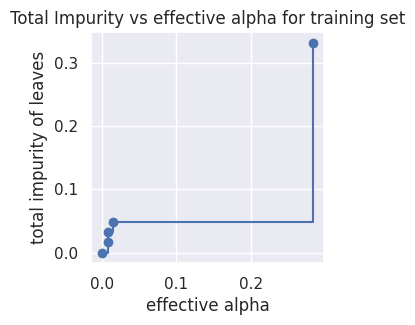

In [455]:
#returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process.
path = clf_of.cost_complexity_pruning_path(X_train_of, y_train_of)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots(figsize=(3,3))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set");

Higher alpha means more pruning. The leaves will be more and more impure. But the things is, we want the model to be more impure for the training so it can better generalize to the test data. So this doesn't tell us the whole story

Number of nodes in the last tree is: 1 with ccp_alpha: 0.33395833333333336


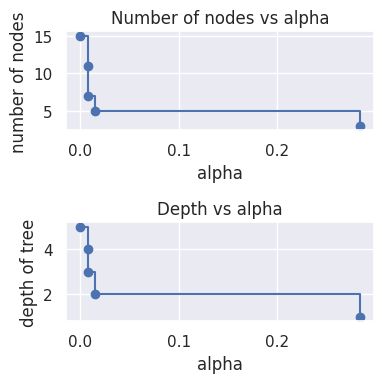

In [456]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf_ = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_.fit(X_train_of, y_train_of)
    clfs.append(clf_)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1,figsize=(4,4))
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

higher alpha (more pruning) also means less nodes and lower tree depth.

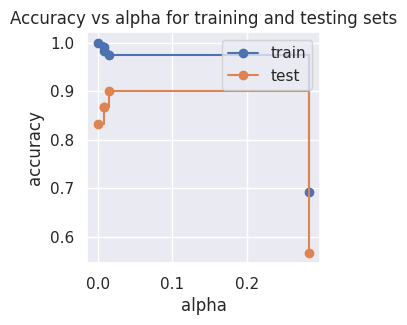

In [457]:
train_scores = [clf.score(X_train_of, y_train_of) for clf in clfs]
test_scores = [clf.score(X_test_of, y_test_of) for clf in clfs]

fig, ax = plt.subplots(figsize=(3,3))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

Now this is showing what we care about. We want to improve the test accuracy at the expense of decreasing the train accuracy. Therefore an alpha of 0.1 should be good.

In [467]:
clf_ = DecisionTreeClassifier(random_state=0, ccp_alpha=0.1)
clf_.fit(X_train_of, y_train_of)
clf_.score(X_test_of, y_test_of)

score_train = clf.score(X_train_of,y_train_of)
score_test = clf.score(X_test_of, y_test_of)
print("BEFORE PRUNING")
print(f"Training set score: {score_train:.2f}")
print(f"Testing set score: {score_test:.2f}")
print(" ")

print("AFTER PRUNING")
score_train_prune = clf_.score(X_train_of,y_train_of)
score_test_prune = clf_.score(X_test_of, y_test_of)
print(f"Training set score: {score_train_prune:.2f}")
print(f"Testing set score with prune: {score_test_prune:.2f}")

BEFORE PRUNING
Training set score: 1.00
Testing set score: 0.83
 
AFTER PRUNING
Training set score: 0.97
Testing set score with prune: 0.90


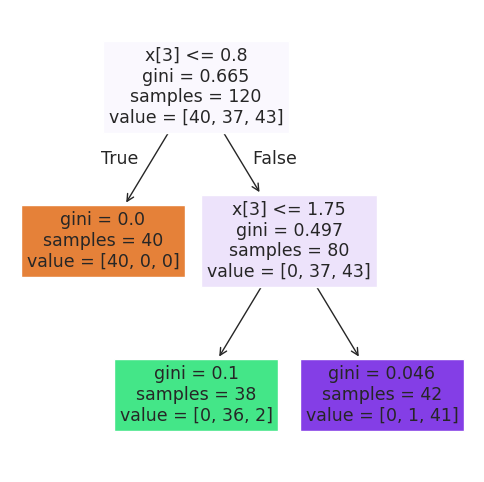

In [468]:
plt.figure(figsize=(6,6))
plot_tree(clf_, filled=True);